# Jupyter notebook for downloading ECMWF AIFS data

**Artificial Intelligence/Integrated Forecasting System (AIFS)**  
The Artificial Intelligence/Integrated Forecasting System (AIFS) is a global forecasting system developed by the European Centre for Medium-Range Weather Forecasts (ECMWF). It is a machine learning–based model that complements the traditional physics-based Integrated Forecasting System (IFS).  
AIFS was built using the Anemoi toolkit, which provides scalable components and pipelines for developing and training large AI-driven weather forecasting models.  
(Source: [ECMWF Newsletter No. 178](https://www.ecmwf.int/en/newsletter/178/news/aifs-new-ecmwf-forecasting-system))

**Operational configurations**  
AIFS includes two operational configurations:  
- AIFS Single (deterministic model), operational since 25 February 2025  
- AIFS Ensemble (ensemble model), operational since 1 July 2025  
(References: [AIFS Single v1](https://www.ecmwf.int/en/forecasts/documentation-and-support/changes-ecmwf-model/aifs-single-v1-implementation), [AIFS ENS](https://www.ecmwf.int/en/forecasts/documentation-and-support/changes-ecmwf-model/aifs-ens-implementation))

**Forecast production**  
Forecasts are produced four times per day (00, 06, 12, and 18 UTC) and extend to 15 days ahead in 6-hourly forecast steps. All runs are initialised from the ECMWF operational analysis and are generated on the N320 grid (approximately 0.25° × 0.25°).  
Open data are disseminated in GRIB2 format using World Meteorological Organization (WMO) standard units.  
(Source: [AIFS Machine Learning Data](https://www.ecmwf.int/en/forecasts/dataset/aifs-machine-learning-data))

The figure below provides an overview of the main input and output fields used for training and prediction in AIFS.
![alt text](image.png)

**Data access**  
Real-time data from AIFS Single are distributed immediately after forecast completion, following the removal of the previous one-hour delay. 

**Important data availability notes:**
- **ECMWF Open Data**: Provides free access to AIFS forecasts, but only retains approximately the **last 4 days** of data. This is the access method used in this notebook. Today's data may not be complete yet so I skipped it. If only 00:00 was being downloaded then I could have included today but I did not.
- **ECMWF MARS archive**: Contains the complete historical AIFS archive dating back to operational start (February 2025 for AIFS Single). Access to MARS requires ECMWF membership or a special license agreement.

For internal ECMWF users, AIFS products can be accessed in the Product Requirements Editor by specifying `class=ai`. Available parameters are listed under Group D: AIFS.

**Training data**  
The current AIFS version was trained on ERA5 reanalysis data (1979–2018) and fine-tuned on operational IFS forecasts (2019–2020). The model uses both pressure-level and surface variables, along with auxiliary forcing information such as time of year and solar radiation (insolation).  
Training inputs and outputs were produced at about 1° resolution.  
(Source: [ECMWF Newsletter 178](https://www.ecmwf.int/en/newsletter/178/news/aifs-new-ecmwf-forecasting-system))

**Further reading and my references**  
- [Machine Learning for Forecasters - Part 1](https://events.ecmwf.int/event/493/contributions/5308/attachments/3069/5634/ML_for_forecasters-1.pdf)
- [Machine Learning for Forecasters - Part 2](https://events.ecmwf.int/event/493/contributions/5307/attachments/3071/5635/ML_for_forecasters-2.pdf)



**Content of this notebook (AIFS)**

This notebook explains how to access ECMWF's AIFS data and how to download a custom-tailored subset using ECMWF Open Data and `xarray/cfgrib`. In this notebook the AIFS **deterministic** configuration (AIFS Single) is used.

**What we download:**

- spatial domain: global  
- native resolution: 0.25° × 0.25° (N320 grid)  
- temporal extent: 3 recent days available in ECMWF Open Data  
- forecast initialization: 12 UTC only  
- forecast steps: +6h, +12h, +24h (3 steps per day)  
- variables: 2m temperature (2t), 10m u-wind (10u), 10m v-wind (10v), mean sea level pressure (msl)  
- level type: surface fields only  
- output format: GRIB2

**Workflow:**

1. Install required tools: `ecmwf-opendata`, `xarray`, `cfgrib`, `eccodes`, `cartopy`  
2. Configure download settings (dates, forecast steps, variables)  
3. Download AIFS Single surface fields from ECMWF Open Data  
4. Open GRIB2 files with `xarray/cfgrib` for inspection  
5. Visualize global 2m temperature on a map using `matplotlib` and `cartopy`



**Exercise: Estimate the data volume of a single variable!**
**Exercise: estimate the data volume that you will download**
Answers to the exercise and today is 30th of November.

AIFS single started February 25th which is 279 days or 1116 hours (assuming 4 cycles per day data available)
1116 hours * 4 bytes/val(hour) = 4464 bytes = 4.36 KB for one grid point and one variable (assuming 4 hours per day data available)

assuming 0.25° × 0.25° grid size, we have 180/0.25 * 360/0.25 = 1440 * 720 = 1036800 grids 
1036800 grids * 4.36 KB = around 4.52 GB (globally and hourly data for one variable) 
4.52 * 13 pressure levels = 58.76 GB (data for one variable for each pressure level)
(22 surface variables + 6 (pressure level parameters) * 13 pressure levels) = 100 fields per time
100 * 4.52 = 452 GB whole data volume


If we check per time: 100 variables * 4 bytes * 1036800 grids = 0.415 GB global data per time

4 cycles/day 

279 days (since Feb 25)

= 4 × 279 = 1116 time slices

0.415 GB * 1116 = 463 GB all variables for all time

---

**Data volume for one file we download:**

One file contains: 4 variables (2t, 10u, 10v, msl) at one forecast step

Theoretical (uncompressed): 4 variables * 4 bytes * 1036800 grids = 0.0166 GB = 16.6 MB per file

Actual (GRIB2 compressed): **~2.4 MB per file** (.grib2 compresses data. It initially results in a 32% reduction in the volume of data produced. Further, a reduction of 42% is possible given the completion of the progressive migration from GRIB1 to GRIB2.)
(https://www.ecmwf.int/en/elibrary/81320-impact-grib-compression-weather-forecast-data-and-data-handling-applications)

Therefore, 16.6 MB* 0.32* 0.42=2.23MB which resembels the actual file size

In [ ]:
# Import required libraries
import earthkit.data  # reader/downloader for ECMWF Open Data
import earthkit.plots 
from pathlib import Path
from datetime import datetime, timedelta  # added timedelta for date calculations
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
os.environ["ECMWF_OD_USE_INDEX"] = "0"


In [ ]:
# Configure download settings and create file naming function

# Get the last 4 available days
# ECMWF Open Data typically retains the most recent 4 days (https://data.ecmwf.int/forecasts/)
today = datetime.now()
dates_list = []

# Start from yesterday and go back to get 3 days

for i in range(1, 4):
    date = today - timedelta(days=i)
    dates_list.append(date.strftime("%Y-%m-%d"))

# Reverse to get chronological order (oldest to newest)
dates_list.reverse()

print("Dates to download:", dates_list)

CFG = {
    "source": "ecmwf-open-data",
    "model": "aifs-single",              # deterministic AIFS (Open Data id)
    "dates": dates_list,                 # list of 4 days
    "time": 12,                  
    "steps": [6, 12, 24],       
    "levtype": "sfc",             
    "params": ["2t", "10u", "10v", "msl"],
    "out_dir": "./data/aifs",     
}

OUT = Path(CFG["out_dir"]).resolve()
OUT.mkdir(parents=True, exist_ok=True)
print("OUT dir:", OUT)


def out_name(cfg, date, step):
    # Remove dashes from date string (e.g., '2025-11-09' becomes '20251109')
    clean_date = date.replace("-", "")
    # Build the output filename with all relevant info
    filename = (
        f"{cfg['model']}_"          # model name
        f"{clean_date}_"                   # date without dashes
        f"{cfg['time']:02d}_"              # run time, padded to 2 digits
        f"{cfg['levtype']}_"                            # level type
        f"step{step:03d}_"                 # forecast step, padded to 3 digits
        f"0p25.grib2"                      # resolution + format
    )
    return filename


Dates to download: ['2025-11-27', '2025-11-28', '2025-11-29']
OUT dir: D:\workspace\earth_system\earth-system-data-processing\data_access\data\aifs


In [ ]:
# Download AIFS forecast data

# Loop through each date in our list
for date in CFG["dates"]:
    # For each date, loop through all forecast steps
    for step in CFG["steps"]:
        # Create the output file path
        target_file = OUT / out_name(CFG, date, step)

        print(f"Requesting {date} step {step:3d}h  →  {target_file.name}")

        # Request data from ECMWF Open Data
        ds = earthkit.data.from_source(
            CFG["source"],           # backend: ECMWF Open Data
            model=CFG["model"],      # AIFS deterministic
            stream="oper",           # operational forecast stream
            type="fc",               # forecast product
            date=date,               # current date from loop
            time=CFG["time"],        # run hour (UTC)
            step=step,               # forecast lead time in hours
            levtype=CFG["levtype"],  # level type (surface)
            param=CFG["params"],     # variables to download
            target=str(target_file), # local GRIB2 file to save
        )

        # Check how many data messages were returned
        n = len(ds)
        print(f"Messages returned: {n}")
        if n == 0:
            print("Nothing returned. Check model/date/time/step/levtype/params combo.")
            print(ds.ls())  # diagnostic listing
            continue

        # Save the data to file
        ds.save(str(target_file))
        print("Saved:", target_file, "size:", target_file.stat().st_size)


Requesting 2025-11-27 step   6h  →  aifs-single_20251127_12_sfc_step006_0p25.grib2


Messages returned: 4
Saved: D:\workspace\earth_system\earth-system-data-processing\data_access\data\aifs\aifs-single_20251127_12_sfc_step006_0p25.grib2 size: 2554414
Requesting 2025-11-27 step  12h  →  aifs-single_20251127_12_sfc_step012_0p25.grib2


Messages returned: 4
Saved: D:\workspace\earth_system\earth-system-data-processing\data_access\data\aifs\aifs-single_20251127_12_sfc_step012_0p25.grib2 size: 2632869
Requesting 2025-11-27 step  24h  →  aifs-single_20251127_12_sfc_step024_0p25.grib2


Messages returned: 4
Saved: D:\workspace\earth_system\earth-system-data-processing\data_access\data\aifs\aifs-single_20251127_12_sfc_step024_0p25.grib2 size: 2591758
Requesting 2025-11-28 step   6h  →  aifs-single_20251128_12_sfc_step006_0p25.grib2


Messages returned: 4
Saved: D:\workspace\earth_system\earth-system-data-processing\data_access\data\aifs\aifs-single_20251128_12_sfc_step006_0p25.grib2 size: 2692767
Requesting 2025-11-28 step  12h  →  aifs-single_20251128_12_sfc_step012_0p25.grib2


Messages returned: 4
Saved: D:\workspace\earth_system\earth-system-data-processing\data_access\data\aifs\aifs-single_20251128_12_sfc_step012_0p25.grib2 size: 2528495
Requesting 2025-11-28 step  24h  →  aifs-single_20251128_12_sfc_step024_0p25.grib2


Messages returned: 4
Saved: D:\workspace\earth_system\earth-system-data-processing\data_access\data\aifs\aifs-single_20251128_12_sfc_step024_0p25.grib2 size: 2482826
Requesting 2025-11-29 step   6h  →  aifs-single_20251129_12_sfc_step006_0p25.grib2


Messages returned: 4
Saved: D:\workspace\earth_system\earth-system-data-processing\data_access\data\aifs\aifs-single_20251129_12_sfc_step006_0p25.grib2 size: 2574537
Requesting 2025-11-29 step  12h  →  aifs-single_20251129_12_sfc_step012_0p25.grib2


Messages returned: 4
Saved: D:\workspace\earth_system\earth-system-data-processing\data_access\data\aifs\aifs-single_20251129_12_sfc_step012_0p25.grib2 size: 2528634
Requesting 2025-11-29 step  24h  →  aifs-single_20251129_12_sfc_step024_0p25.grib2


Messages returned: 4
Saved: D:\workspace\earth_system\earth-system-data-processing\data_access\data\aifs\aifs-single_20251129_12_sfc_step024_0p25.grib2 size: 2475448


# Inspect and Visualize AIFS Data

**Objective:**  
Open one downloaded GRIB2 file, inspect its contents, and create a global temperature map.

**What we plot:**  
Global 2-meter temperature (°C) on a Robinson projection map. The plot shows the most recent date at the +24h forecast step.

skipping variable: paramId==165 shortName='u10'
Traceback (most recent call last):
  File "c:\Users\90542\miniconda3\envs\aifs\Lib\site-packages\cfgrib\dataset.py", line 726, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "c:\Users\90542\miniconda3\envs\aifs\Lib\site-packages\cfgrib\dataset.py", line 642, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='heightAboveGround' value=Variable(dimensions=(), data=np.float64(2.0)) new_value=Variable(dimensions=(), data=np.float64(10.0))
skipping variable: paramId==166 shortName='v10'
Traceback (most recent call last):
  File "c:\Users\90542\miniconda3\envs\aifs\Lib\site-packages\cfgrib\dataset.py", line 726, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "c:\Users\90542\miniconda3\envs\aifs\Lib\site-packages\cfgrib\dataset.py", line 642, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key pre

<xarray.Dataset> Size: 8MB
Dimensions:            (latitude: 721, longitude: 1440)
Coordinates:
  * latitude           (latitude) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude          (longitude) float64 12kB -180.0 -179.8 ... 179.5 179.8
    time               datetime64[ns] 8B ...
    step               timedelta64[ns] 8B ...
    heightAboveGround  float64 8B ...
    valid_time         datetime64[ns] 8B ...
    meanSea            float64 8B ...
Data variables:
    t2m                (latitude, longitude) float32 4MB ...
    msl                (latitude, longitude) float32 4MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-11-10T12:37 GRIB to CDM+CF via cfgrib-0.9.1...
Data variabl

c:\Users\90542\miniconda3\envs\aifs\Lib\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\90542\miniconda3\envs\aifs\Lib\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\90542\miniconda3\envs\aifs\Lib\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\90542\miniconda3\envs\aifs\Lib\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


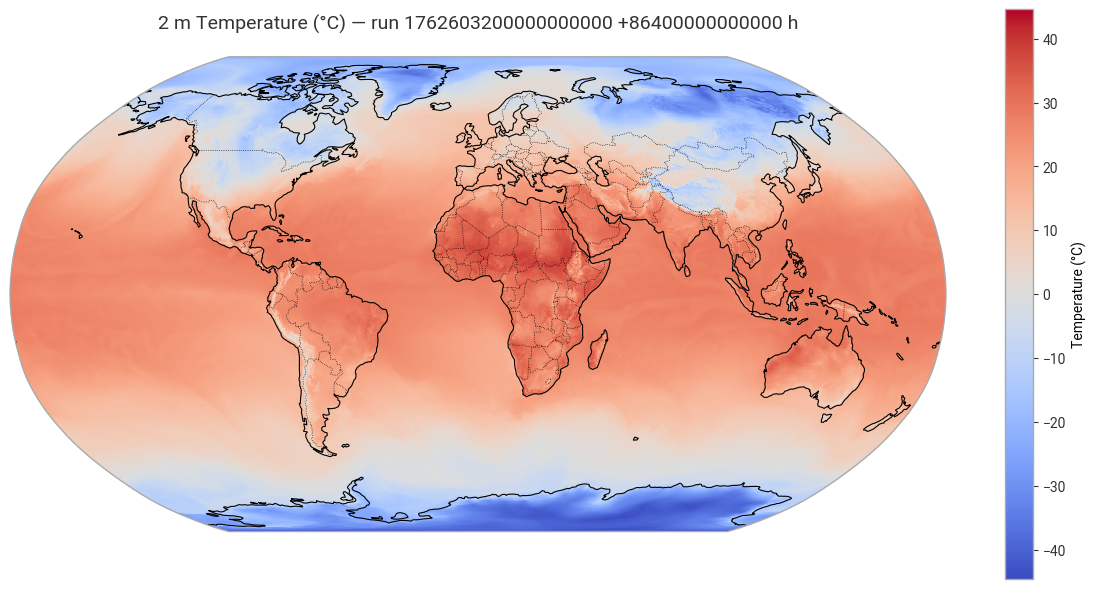

In [ ]:
# Inspect and visualize downloaded GRIB data

# Use the most recent date and longest forecast step for inspection
most_recent_date = CFG["dates"][-1]  # last date in list (most recent)
sample = OUT / out_name(CFG, most_recent_date, 24)
assert sample.exists(), f"File not found: {sample}"

# Open GRIB2 file with xarray using cfgrib engine
# indexpath="" prevents creating .idx files on disk
ds = xr.open_dataset(sample, engine="cfgrib", backend_kwargs={"indexpath": ""})
print(ds)  # structure
print("Data variables:", list(ds.data_vars))
print("Coordinates:", list(ds.coords))

# Check ranges of downloaded variables
if "t2m" in ds:
    # Convert temperature from Kelvin to Celsius
    t2m_c = ds["t2m"] - 273.15
    print("t2m range (°C):", float(t2m_c.min()), "to", float(t2m_c.max()))
if all(v in ds for v in ["u10", "v10"]):
    # Calculate wind speed magnitude from u and v components
    ws10 = np.hypot(ds["u10"], ds["v10"])
    print("ws10 range (m/s):", float(ws10.min()), "to", float(ws10.max()))
if "msl" in ds:
    # Convert pressure from Pascals to hectoPascals (millibars)
    msl_hpa = ds["msl"] / 100.0
    print("msl range (hPa):", float(msl_hpa.min()), "to", float(msl_hpa.max()))

# Create a map visualization using Cartopy
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson())

# Plot 2 meter temperature in Celsius
field = (ds["t2m"] - 273.15)
pc = field.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="coolwarm",
    cbar_kwargs={"label": "Temperature (°C)"},
    add_colorbar=True,
    add_labels=False,
)

# Add map features
ax.coastlines(linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=":")
ax.add_feature(cfeature.LAND, color="lightgray")
ax.add_feature(cfeature.OCEAN, color="lightblue")

# Build title from dataset metadata
ts = str(ds["time"].values.item()) if "time" in ds.coords else "unknown time"
step_val = int(ds["step"].values.item()) if "step" in ds.coords else 24
ax.set_title(f"2 m Temperature (°C) — run {ts} +{step_val} h", fontsize=14, pad=20)

plt.tight_layout()
